# Random Graph Models

**September 08 2020**  
*Vincenzo Perri*

Random graphs are models of networks in which we fix some aggregated characteristic and allow everything else to vary.
This entails that a random graph does not define a single network but rather a probability distribution over possible networks, also referred to as an `ensamble`of networks. 
Ensambles define what is expected at random for networks with the aforementioned fixed aggregated characteristic. This 'expectation' is particularly useful as, by comparison, it tells us what is unexpected and thus interesting.  

Pathpy provides build-generators for random graph models. In this notebook we study the properties of the generated networks and compare them to those of empirical networks.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

## The $G(n,m)$ model by Pál Erdös and Alred Rényi

The $G(n,m)$ models model generates the ensamble of graphs with $n$ nodes and $m$ edges. 

A number of random graph models (among them $G(n,m)$ and $G(n,p)$) are implemented in the `pathpy` module `generators`. To generate random graphs using the $G(n,m)$ model we can write:

In [2]:
# pp.generators.ER_nm(30, 40, directed=False)

We can also generate networks directed or undirected with or without loops and with multiple edges.


Note that there is a limit to the number of (non multi-) edges that can be put in a graph. If you want to quickly check the maximum number of possible edges for such networks with a given number of nodes, you can use the `max_edges` functions. 

In [3]:
print(pp.generators.max_edges(100, directed=True, loops=True))
print(pp.generators.max_edges(100, directed=True, loops=False))
print(pp.generators.max_edges(100, directed=False, loops=True))
print(pp.generators.max_edges(100, directed=False, loops=False))

10000
9900
5050
4950


In any case, if we specify parameters of an impossible network, the function issues the appropriate error message:

In [4]:
pp.generators.ER_nm(n=100, m=5060, directed=False, loops=True)

[09-07 14:31:49: ERROR] Given network type with n nodes can have at most 5050 edges.


## The $G(n,p)$ model by Edgar Nelson Gilbert

A downside of the $G(n,m)$ model is that links are not generated independely. We can address this with another model originally proposed by Edgar Nelson Gilbert. It assumes that we initially generate n isolated nodes, then connecting each pair of nodes with a fixed probability p (i.e. through a Bernoulli trial):

We can use the function `pp.generators.ER_np` to generate networks according to the $G(n,p)$ model:

In [5]:
pp.generators.ER_np(n=100, p=0.02)

## Randomizing networks

We often use random graph models to randomize the topology of a given network, while keeping their aggregate characteristics. 

To simplify the generation of random microstates that preserve the macrostate of an empirical network, the functions in the module `pathpy.generators` come in a `randomize` version, which automatically preserve the corresponding macrostate of a given network. In the case of the $G(n,p)$ model this automatically adjust the parameters $n$ and $p$ such that the expected number of links matches the observed number of links in the given network.. To see how this works, consider the following example network:

In [6]:
n_undirected = pp.Network(directed=False)
n_undirected.add_edge('a', 'b')
n_undirected.add_edge('b', 'c')
n_undirected.add_edge('c', 'a')
n_undirected.add_edge('d', 'e')
n_undirected.add_edge('e', 'f')
n_undirected.add_edge('f', 'g')
n_undirected.add_edge('g', 'd')
n_undirected.add_edge('d', 'f')
n_undirected.add_edge('b', 'd')
n_undirected.plot()

We can use the $G(n,m)$ model to generate a random version of this network with the same number of nodes, edges, the same edge directedness and the same node uids as follows

In [7]:
pp.generators.ER_nm_randomize(n_undirected)

We can do the swme for the $G(n,p)$ model. Here the parameter $p$ is automatically fitted to the given network, i.e. it is chosen such that the number of *expected links* in the generated microstates matches the number of links in the given network:

In [8]:
pp.generators.ER_np_randomize(n_undirected)

## Degree distribution of random $G(n,m)$ vs. empirical networks


Let us now study the degree distribution of random graphs, comparing them to the degree distributions of empirical networks. For this, we first load three empirical networks:

In [41]:
n_gentoo = pp.io.sql.read_network('networks.db', sql='SELECT source, target FROM gentoo', directed=False)
n_highschool = pp.io.sql.read_network('networks.db', sql='SELECT source, target FROM highschool', directed=False, multiedges = True )
n_lotr = pp.io.sql.read_network('networks.db', sql='SELECT source, target FROM "lotr"', directed=False, multiedges = True).largest_connected_component()

For each network, we first plot the empirical degree distribution.

We then use the `ER_nm_randomize` function to generate a random microstate where the model parameters of the underlying $G(n,m)$ model have been adjusted to the number of nodes and links in the empirical network:

In [10]:
er_gentoo = pp.generators.random_graphs.ER_nm_randomize(n_gentoo)
er_highschool = pp.generators.random_graphs.ER_nm_randomize(n_highschool)
er_lotr = pp.generators.random_graphs.ER_nm_randomize(n_lotr)

**highschool**

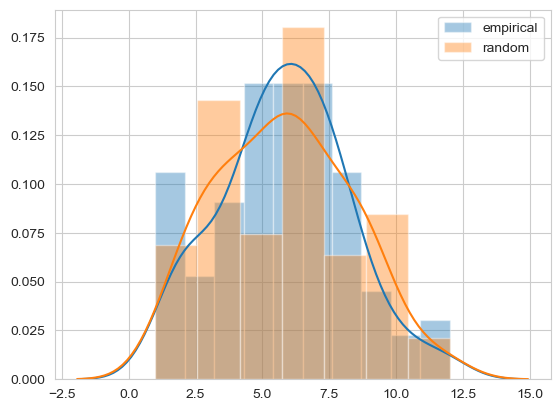

In [11]:
sns.distplot(n_highschool.degree_sequence(), label="empirical");
sns.distplot(er_highschool.degree_sequence(), label = "random");
plt.legend()

**lotr**

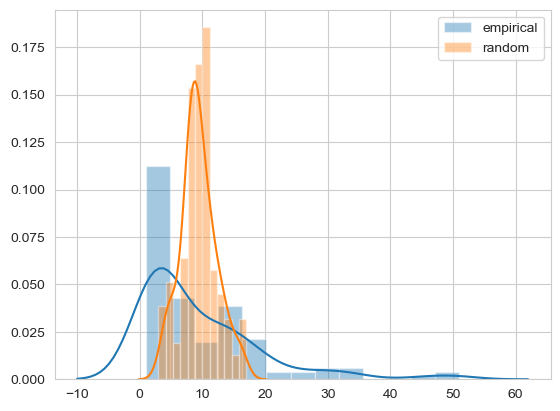

In [12]:
sns.distplot(n_lotr.degree_sequence(), label="empirical");
sns.distplot(er_lotr.degree_sequence(), label = "random");
plt.legend()

**gentoo**

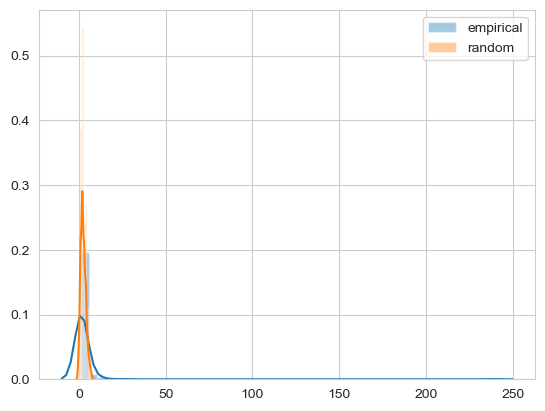

In [13]:
sns.distplot(n_gentoo.degree_sequence(), label="empirical");
sns.distplot(er_gentoo.degree_sequence(), label = "random");
plt.legend()

In particular for this last network, we find that the degree distribution of the random network is much more narrow than that of the empirical network. In other words: Compared to a simple random graph model this broad degree distribution actually constitutes an interesting pattern that we seek to model and explain.

## Configuration Model

Above we investigated ensambles generated fixing properties such as the number of edges or the average degree. 
As we saw above the degree distributions of random networks grossly differ from that of the real networks.
We may want to generalize random graph models so that the fixed property is the degree distribution.
This is exactly what the Molloy-Reed model -also called configuration model- does, providing a way to generate random graphs with any *graphic* degree sequence. 

In sentence above we highlighted the "graphic" because not every sequence is compatible with being the degree sequence of a graph.
In pathpy we can test whether a sequence is graphic (i.e. whether a graph exists that has the sequence as degree sequence) with the `is_graphic_Erdos_Gallai` function in the `generators`module:

In [14]:
graphic_sequence = [1,2,2,3]
pp.generators.is_graphic_Erdos_Gallai(graphic_sequence)

True

In [15]:
non_graphic_sequence = [2,2,2,3]
pp.generators.is_graphic_Erdos_Gallai(non_graphic_sequence)

False

Graphic sequences are relevant since with them we can implement the Molloy-Reed/Configuration model, which generates random networks with an arbitrary degree distribution. This model is implemented by the following function:

In [16]:
pp.generators.Molloy_Reed(graphic_sequence)

if we try to pass sequence that is not graphic (do we get an error message?):

In [17]:
pp.generators.Molloy_Reed(non_graphic_sequence)

We can look at the degree sequences generated from the Molloy-Reed model and confirm that they are identical to those of the empirical networks.

For the Molloy-Reed model, the `_randomize` method fixes the degree sequence of the empirical network in the generation of a random microstate. All other network properties like, e.g. node uids are preserved. 

In [18]:
mr_gentoo = pp.generators.random_graphs.Molloy_Reed_randomize(n_gentoo)
mr_highschool = pp.generators.random_graphs.Molloy_Reed_randomize(n_highschool)
mr_lotr =  pp.generators.random_graphs.Molloy_Reed_randomize(n_lotr)

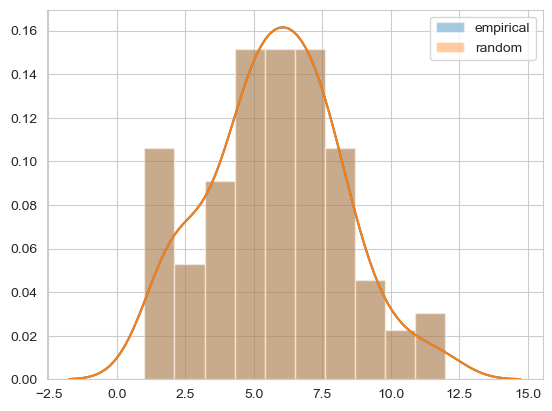

In [19]:
sns.distplot(n_highschool.degree_sequence(), label="empirical");
sns.distplot(mr_highschool.degree_sequence(), label = "random");
plt.legend()

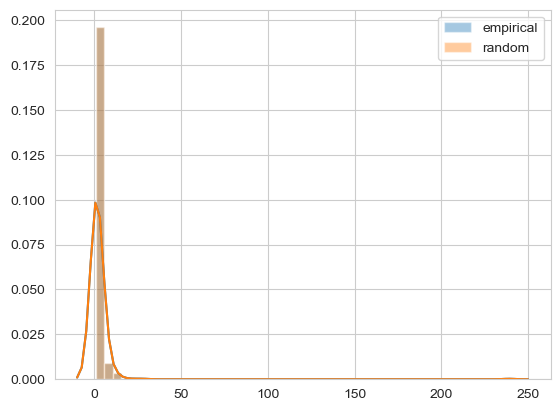

In [20]:
sns.distplot(n_gentoo.degree_sequence(), label="empirical");
sns.distplot(mr_gentoo.degree_sequence(), label = "random");
plt.legend()

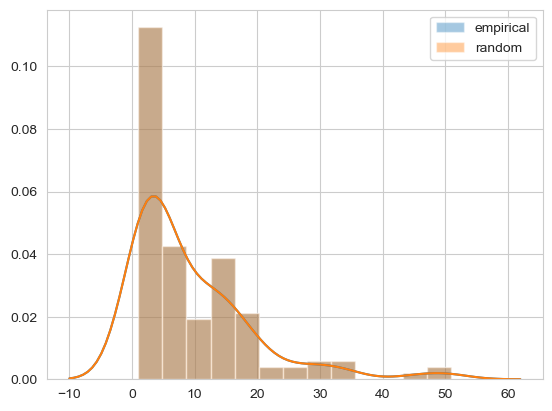

In [21]:
sns.distplot(n_lotr.degree_sequence(), label="empirical");
sns.distplot(mr_lotr.degree_sequence(), label = "random");
plt.legend()

we can also generate networks with a fixed degree distribution rather than a fixed degree sequence. For this we first draw degree sequences from a given distribution, check whether the sequence is graphic and then apply the model above. Below, we apply this to a sequence of 300 degrees drawn from a *Zipf* distribution with parameter $\gamma=2.7$.

In [22]:
degrees_zipf = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees_zipf):
    degrees_zipf = [int(x) for x in np.random.zipf(2.5, 300)]

g_zipf = pp.generators.Molloy_Reed(degrees_zipf)
# g_zipf.plot()

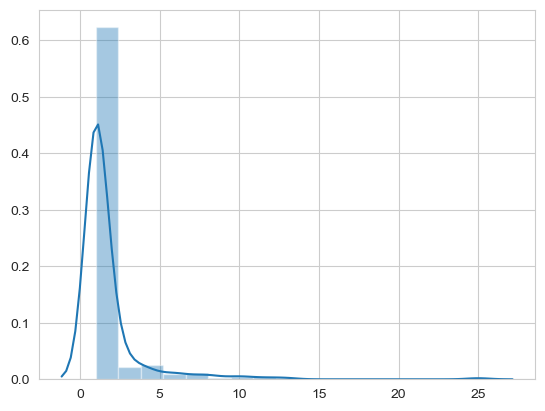

In [23]:
sns.distplot(pp.statistics.degree_sequence(g_zipf));

# Diameter and clustering coefficient of random networks vs. empirical networks

An important application of the Molloy-Reed model in statistical network analysis is as a null model that helps us to establish a baseline for what we can expect at random, if we account for the heterogeneous degrees in a real network. To show the advantage over simple rrandom graph models that only preserve the size of the network, we make an experiment with real data. We compare the diameter and average shortest path length of the largest connected component in empirical networks with those of random microstates generated using the $G(n,p)$ and the Molloy-Reed model.

Before performing the comparison we must the connectedness of the networks.

In [24]:
print("\nemp")
print(n_gentoo.is_connected)
print(n_highschool.is_connected)
print(n_lotr.is_connected)

print("\nG(n,m)")
print(er_gentoo.is_connected)
print(er_highschool.is_connected)
print(er_lotr.is_connected)

print("\nmolloy reed")
print(mr_gentoo.is_connected)
print(mr_highschool.is_connected)
print(mr_lotr.is_connected)


emp
True
True
True

G(n,m)
False
True
True

molloy reed
False
True
True


For gentoo the random realization is not connected, which would lead to an infinite diameter and average shortest path length. To still allow for an approximate comparison, we can compute the calculations on the largest connected component.

In [25]:
er_gentoo = pp.generators.random_graphs.ER_np_randomize(er_gentoo).largest_connected_component()
mr_gentoo = pp.generators.random_graphs.ER_np_randomize(n_gentoo).largest_connected_component()
print("Empirical network has", n_gentoo.number_of_nodes(), "nodes and", n_gentoo.number_of_edges(), "edges")
print("G(n,p) microstate has", er_gentoo.number_of_nodes(), "nodes and", er_gentoo.number_of_edges(), "edges")
print("Molloy-Reed microstate has", mr_gentoo.number_of_nodes(), "nodes and", mr_gentoo.number_of_edges(), "edges")

Empirical network has 403 nodes and 513 edges
G(n,p) microstate has 362 nodes and 505 edges
Molloy-Reed microstate has 350 nodes and 470 edges


In [33]:
#GENTOO
# Empirical 
diameter_n_gentoo = n_gentoo.largest_connected_component().diameter()
avg_pl_n_gentoo = pp.algorithms.avg_path_length(n_gentoo)
avg_clst_n_gentoo = n_gentoo.avg_clustering_coefficient()
# G(n,p)
diameter_er_gentoo = er_gentoo.diameter()
avg_pl_er_gentoo = pp.algorithms.avg_path_length(er_gentoo)
avg_clst_er_gentoo = er_gentoo.avg_clustering_coefficient()
# Molloy-Reed
diameter_mr_gentoo = mr_gentoo.diameter()
avg_pl_mr_gentoo = pp.algorithms.avg_path_length(mr_gentoo)
avg_clst_mr_gentoo = mr_gentoo.avg_clustering_coefficient()
print("\ngentoo\n----------")
print("empirical")
print('Diameter = ', diameter_n_gentoo)
print('Avg path length = ', avg_pl_n_gentoo)
print('Clustering coefficient = ', avg_clst_n_gentoo)
print("----------")
print("$G(n,m)")
print('Diameter = ', diameter_er_gentoo)
print('Avg path length = ', avg_pl_er_gentoo)
print('Clustering coefficient = ', avg_clst_er_gentoo)
print("----------")
print("Molloy-Reed")
print('Diameter = ', diameter_mr_gentoo)
print('Avg path length = ', avg_pl_mr_gentoo)
print('Clustering coefficient = ', avg_clst_mr_gentoo)


gentoo
----------
empirical
Diameter =  8.0
Avg path length =  3.1096379146451367
Clustering coefficient =  0.017357355654577633
----------
$G(n,m)
Diameter =  13.0
Avg path length =  6.056029139437719
Clustering coefficient =  0.007903621853898098
----------
Molloy-Reed
Diameter =  14.0
Avg path length =  6.468882521489971
Clustering coefficient =  0.00219047619047619


For **gentoo** we find that the diameter and the average shortest path length of the largest connected component of the random realizations are larger than that of the empirical network. Both the randomized and the empirical networks have low clustering coefficient. 

In [31]:
# HIGHSCHOOL
# Empirical 
diameter_n_highschool = n_highschool.diameter()
avg_pl_n_highschool = pp.algorithms.avg_path_length(n_highschool)
avg_clst_n_highschool = n_highschool.avg_clustering_coefficient()
# G(n,p)
diameter_er_highschool = er_highschool.diameter()
avg_pl_er_highschool = pp.algorithms.avg_path_length(er_highschool)
avg_clst_er_highschool = er_highschool.avg_clustering_coefficient()
# Molloy-Reed
diameter_mr_highschool = mr_highschool.diameter()
avg_pl_mr_highschool = pp.algorithms.avg_path_length(mr_highschool)
avg_clst_mr_highschool = mr_highschool.avg_clustering_coefficient()
print("\nhighschool\n----------")
print("empirical")
print('Diameter = ', diameter_n_highschool)
print('Avg path length = ', avg_pl_n_highschool)
print('Clustering coefficient = ', avg_clst_n_highschool)
print("----------")
print("$G(n,m)")
print('Diameter = ', diameter_er_highschool)
print('Avg path length = ', avg_pl_er_highschool)
print('Clustering coefficient = ', avg_clst_er_highschool)
print("----------")
print("Molloy-Reed")
print('Diameter = ', diameter_mr_highschool)
print('Avg path length = ', avg_pl_mr_highschool)
print('Clustering coefficient = ', avg_clst_mr_highschool)


highschool
----------
empirical
Diameter =  12.0
Avg path length =  5.362745098039215
Clustering coefficient =  0.446799543049543
----------
$G(n,m)
Diameter =  5.0
Avg path length =  2.8901960784313725
Clustering coefficient =  0.04981301106301106
----------
Molloy-Reed
Diameter =  5.0
Avg path length =  2.87296918767507
Clustering coefficient =  0.03968193843193843


For **highschool** the diameter and average path lengths of the random realization are smaller than that of the empirical network, i.e. we find the opposite case compared to the gentoo network. The clustering coefficient of the empirical network is much higher than that of the randomized ones.

In [34]:
# LOTR
# Empirical 
diameter_n_lotr = n_lotr.diameter()
avg_pl_n_lotr = pp.algorithms.avg_path_length(n_lotr)
avg_clst_n_lotr = n_lotr.avg_clustering_coefficient()
# G(n,p)
diameter_er_lotr = er_lotr.diameter()
avg_pl_er_lotr = pp.algorithms.avg_path_length(er_lotr)
avg_clst_er_lotr = er_lotr.avg_clustering_coefficient()
# Molloy-Reed
diameter_mr_lotr = mr_lotr.diameter()
avg_pl_mr_lotr = pp.algorithms.avg_path_length(mr_lotr)
avg_clst_mr_lotr = mr_lotr.avg_clustering_coefficient()
print("\nlotr\n----------")
print("empirical")
print('Diameter = ', diameter_n_lotr)
print('Avg path length = ', avg_pl_n_lotr)
print('Clustering coefficient = ', avg_clst_n_lotr)
print("----------")
print("$G(n,m)")
print('Diameter = ', diameter_er_lotr)
print('Avg path length = ', avg_pl_er_lotr)
print('Clustering coefficient = ', avg_clst_er_lotr)
print("----------")
print("Molloy-Reed")
print('Diameter = ', diameter_mr_lotr)
print('Avg path length = ', avg_pl_mr_lotr)
print('Clustering coefficient = ', avg_clst_mr_lotr)


lotr
----------
empirical
Diameter =  6.0
Avg path length =  2.6724273369992146
Clustering coefficient =  0.5848854454659763
----------
$G(n,m)
Diameter =  4.0
Avg path length =  2.4193693188194367
Clustering coefficient =  0.0709528643242427
----------
Molloy-Reed
Diameter =  6.0
Avg path length =  2.530580181797778
Clustering coefficient =  0.2542657678421987


For **lotr** we observe that the diameter of the $G(n,m)$ is slightly smaller than that of the empirical network. The diameter of the Molloy-Reed microstate instead is in line with that of the empirical network.
Interestingly in this case we see that part of the high value of clustering observed in the empirical network is explained by the degree sequence. 

## Modularity-based Community Detection

We conclude this notebook with an application of modularity-based community detection to empirical networks. 
The partition quality function $Q(n, C)$ that captures how well a given mapping of nodes to communities is aligned with the topology of a network. This function can be used to develop a simple community detection algorithm that is based on the heuristic optimisation of partition quality.

The partition quality $Q(G, C)$ is defined as
$$ Q(G,C) = \frac{1}{2m} \sum_{i,j \in V}\left(A_{ij} - \frac{d_id_j}{2m}\right) \delta(c_i,c_j) $$ where $d_i$ denotes the degree of node $i$ 

In a nutshell it compares the connections actually present between nodes in the same community ($A_{ij}$) with *expected* number of connections between those nodes ($\frac{d_id_j}{2m}$).
If that *expected* caught attention, you are on the right track as this expectation is once again based on the Molloy-Reed model!

In [35]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot()

In [36]:
C, q = pp.algorithms.community_detection.modularity_maximisation(n, iterations=100)
print('Community partition =', C)
print('Modularity =', q)

Community partition = {'f': 0, 'g': 0, 'e': 0, 'd': 0, 'a': 6, 'b': 6, 'c': 6}
Modularity = 0.3641975308641976


We can also use the function `color_map` to generate a color mapping that can be directly passed to the `plot` function:

In [37]:
n.plot(node_color=pp.algorithms.community_detection.color_map(n, C))

In [38]:
C, q = pp.algorithms.community_detection.modularity_maximisation(n_highschool, iterations=2000)


maximising modularity: 100%|███████████████████████████████████████████████████████| 2000/2000 [05:02<00:00,  6.62it/s]


In [39]:
n_highschool.plot(node_color=pp.algorithms.community_detection.color_map(n_highschool, C))

# Molloy-Reed model as null model for empirical networks

An important application of the Molloy-Reed model in statistical network analysis is as a null model that helps us to establish a baseline for what we can expect at random, if we account for the heterogeneous degrees in a real network. To show the advantage over simple rrandom graph models that only preserve the size of the network, we make an experiment with real data. We compare the diameter and average shortest path length of the largest connected component in empirical networks with those of random microstates generated using the $G(n,p)$ and the Molloy-Reed model. 

To simplify the generation of random microstates that preserve the macrostate of an empirical network, the functions in the module `pathpy.generators` come in a `randomize` version, which automatically preserve the corresponding macrostate of a given network. In the case of the $G(n,p)$ model this automatically adjust the parameters $n$ and $p$ such that the expected number of links matches the observed number of links in the given network. For the molloy-Reed model, the degree sequence of the empirical network is used in the generation of a random microstate. All other network properties like, e.g. node uids are preserved. We demonstrate this in the following example: